# Cloudy Modeling of PDR and Dark Regions in Various Limiting Cases
## PS2 - Problem 3 - 3/4/24

This notebook contains code to plot models of a photodissociation and dark region, as calculated by models hw2_pdr.in and variants. 

We will model an initial ‘fiducial’ PDR and then also explore how the structure of the PDR changes as we vary several key parameters (density, abundance, CR ionization rate).  

You already have experience varying the density in a cloudy input file.  To vary abundances we'd like to assume a constant dust-to-metals ratio, so we vary them together by setting the "metals and grains" command. (Note you should leave the grains PAH 3.0 as is.)  Similarly we vary the cosmic ray level by setting an appropriate fractional level.

Make models for 

* Density: log n = 4, 2, 6
* Metals/grains, make models for 1.0, 0.1 and 3.0 metallicity/grains
* CR, make models for 1.0, 0.001 and 1000.0   times the background Cosmic Ray density

The first of each of these is the 'fiducial' PDR. You don't need to do a full 3-d exploration of all parameters, you can explore each quantity (density, metals/grains and CR) along 1-d

Note that in all cases the PDR is set to be illuminated by a stellar blackbody with 43,600 K, log Q 49.3, but we pass the star's light through 1e23 cm2 of hydrogen to effectively extinguish H-ionizing photons.  So we are only modeling the non-ionizing PDR and dark cloud region.

As the light penetrates deeper into the region, it is attenuated by dust, and we follow the model until the attenuation reaches Av=10.  In some cases the model might stop before then (e.g. low metallicity).

Answer the following questions:

* For the fiducial PDR/dark region – how do species ionization and fractions and **molecular compositions** vary with Av?  In each region (low Av, high Av) which processes dominate the heating and cooling rates?

* How does the PDR/dark region structure (species ionization and fractions, **molecular composition** and temperature) vary as we change the key parameters?   Why would these vary in the different limiting cases?

Explain your results and make plots/figures useful for illustrating your points (see below). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import QTable, Table, Column
from astropy import units as u
from astropy.io import ascii
import pandas as pd

%matplotlib inline

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

## Functions to read model outputs

These can be used to read main cloudy input files  .ovr (overview), .mol (species densities), .col (cooling rates and fractions), .het (heating rates and fractions)

Some of these require the pandas library


In [2]:
# Functions for reading main cloudy input files  .ovr (overview), .mol (species densities), .col (cooling rates and fractions), .het (heating rates and fractions)

def read_overview(model_name,path):
    file=path+model_name+'.ovr'
    return(Table.from_pandas(pd.read_table(path+file)))

def read_molecule(model_name,path):
    file=path+model_name+'.mol'
    return(Table.from_pandas(pd.read_table(path+file)))

def read_cooling(model_name,path):
    file=path+model_name+'.col'
    with open(file) as f:
        ftable = f.readlines()
    f.close()
    rows=len(ftable)    
    
    # First find which molecule/processes are listed in the cooling table at a given radii
    coolstr=[]
    for line in ftable[1:rows]:     # skip comment header
        row = [item.strip() for item in line.split('\t')]
        lrow=len(row)
         # find process string in every other, starting at 6th column
        coolstr=np.concatenate((coolstr,np.array(row[5:lrow:2])))  

    # Make an array of the unique labels from above    
    cool_unique=np.unique(coolstr)

    # Build two arrays to contain the cooling table info, and the cooling fraction
    ulen=len(cool_unique)
    info=['depth_cm','Temp','Heat_tot','Cool_tot','NotUsed']
    coolarr_info=np.zeros((rows-1,5),dtype='float64')
    coolarr_frac=np.zeros((rows-1,ulen),dtype='float64')

    # Now cycle through file again to extract info and cooling fractions for each entry found in the table
    for line,index in zip(ftable[1:rows],np.arange(rows-1)):
        row = [item.strip() for item in line.split('\t')]
        lrow=len(row)
        coolarr_info[index,:]=np.float64(np.array(row[0:5]))
        # find process string in every other, starting at 6th column
        typestr=np.array(row[5:lrow:2])   
        # find fraction is then in every other, starting at 7th column
        val=np.float64(np.array(row[6:lrow:2]))
        for t,v in zip(typestr,val):
            p=np.argwhere(t==cool_unique)
            coolarr_frac[index,p[0]]=v

    t_cool_info=Table(coolarr_info,names=info)
    t_cool_frac=Table(coolarr_frac,names=cool_unique)
    return(t_cool_info,t_cool_frac)

def read_heating(model_name,path):
    file=path+model_name+'.het'
    with open(file) as f:
        ftable = f.readlines()
    f.close()
    # for heating, there may be more rows than we want
    init_rows=len(ftable)    
    rowflg=np.zeros(init_rows)


    # First find which molecule/processes are listed in the heating table at a given radii
    heatstr=[]
    for line,index in zip(ftable[1:init_rows],np.arange(init_rows-1)):     # skip comment header
        row = [item.strip() for item in line.split('\t')]
        lrow=len(row)
        if (lrow>5):
         # find process string in every other, starting at 6th column
            heatstr=np.concatenate((heatstr,np.array(row[5:lrow:2])))  
            rowflg[index+1]=1    # +1 to account for header line
    
    rows=np.sum(rowflg).astype("int64")
    ftable_tmp=np.array(ftable)
    p=np.where(rowflg==1)
    ftable=ftable_tmp[p[0]]   # note this table has no header
    
    # Make an array of the unique labels from above    
    heat_unique=np.unique(heatstr)

    # Build two arrays to contain the cooling table info, and the cooling fraction
    ulen=len(heat_unique)
    info=['depth_cm','Temp','Heat_tot','Cool_tot','NotUsed']
    heatarr_info=np.zeros((rows,5),dtype='float64')    # slightly different from cool arr since no header
    heatarr_frac=np.zeros((rows,ulen),dtype='float64')   # slightly different from cool arr since no header


    # Now cycle through file again to extract info and cooling fractions for each entry found in the table
    for line,index in zip(ftable[0:rows],np.arange(rows)):
        row = [item.strip() for item in line.split('\t')]
        lrow=len(row)
        heatarr_info[index,:]=np.float64(np.array(row[0:5]))
        # find process string in every other, starting at 6th column
        typestr=np.array(row[5:lrow:2])   
        # find fraction is then in every other, starting at 7th column
        val=np.float64(np.array(row[6:lrow:2]))
        for t,v in zip(typestr,val):
            p=np.argwhere(t==heat_unique)
            heatarr_frac[index,p[0]]=v

    t_heat_info=Table(heatarr_info,names=info)
    t_heat_frac=Table(heatarr_frac,names=heat_unique)
    return(t_heat_info,t_heat_frac)


## Example code for reading model outputs

In [3]:
model_name='ps2_pdr_fiducial'
path='./'

t_ovr=read_overview(model_name,path)
t_mol=read_molecule(model_name,path)
t_cool_info,t_cool_frac=read_cooling(model_name,path)
t_heat_info,t_heat_frac=read_heating(model_name,path)


## Example function for making a fractional rate plot

In [4]:
def frac_stackplot(t_frac,x,xlabel,title):

    cm = plt.get_cmap('gist_rainbow')
    y=np.lib.recfunctions.structured_to_unstructured(t_frac.as_array())

    labels=t_frac.colnames
    nlabel=len(labels)

    plt.figure(figsize=(9,6))


    plt.stackplot(x,np.transpose(y),labels=labels,colors=cm(np.arange(len(labels))/len(labels)))
    plt.legend()
    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylabel('Fraction')
    #plt.xscale("log")
    #plt.yscale("log")
    plt.show()


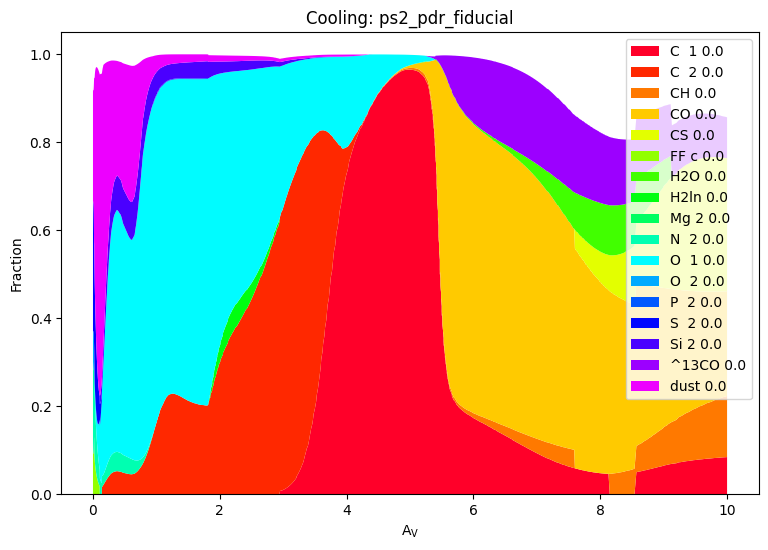

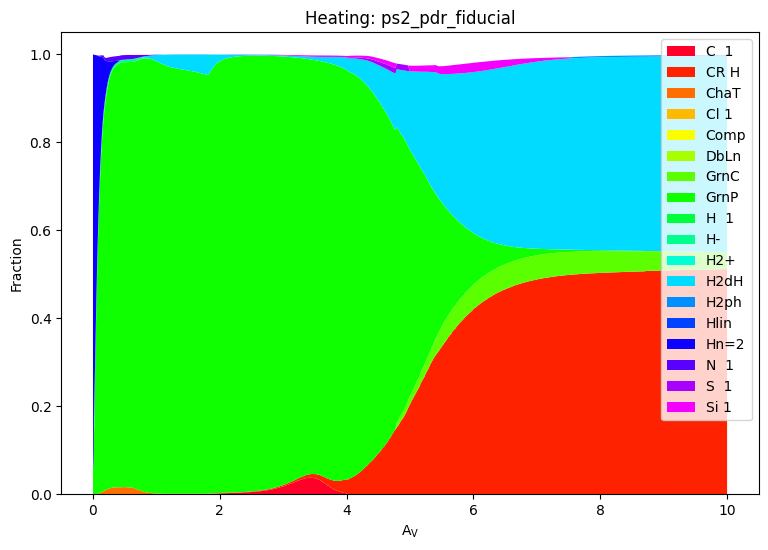

In [5]:
#x=t_cool_info['depth_cm'].data
x=t_ovr['AV(point)'].data
frac_stackplot(t_cool_frac,x,'$A_V$','Cooling: '+model_name)    
frac_stackplot(t_heat_frac,x,'$A_V$','Heating: '+model_name)

## Plot Te, ne vs. Av

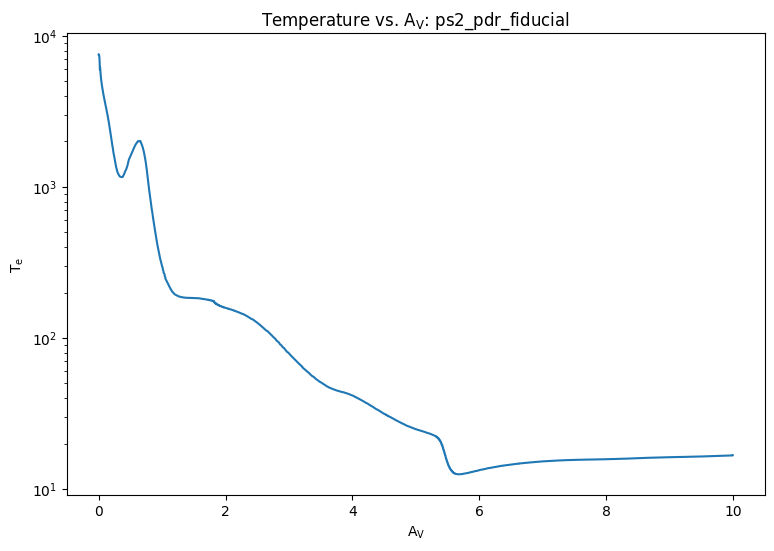

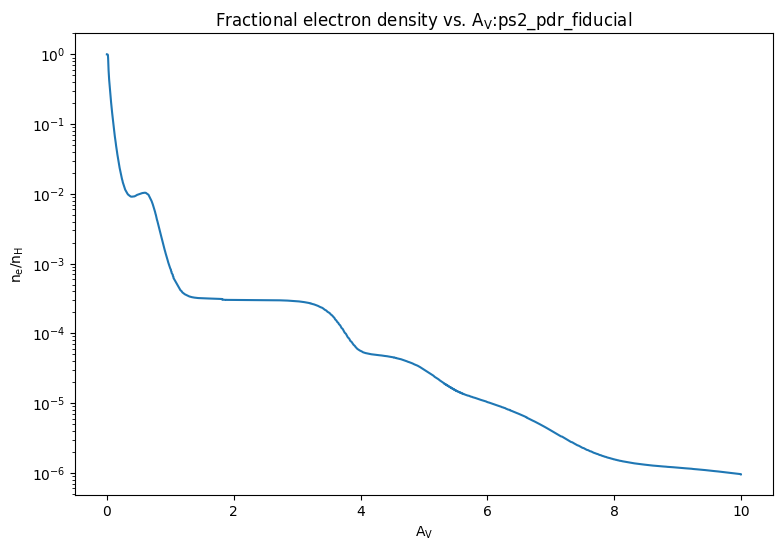

In [6]:
plt.figure(figsize=(9,6))
plt.plot(t_ovr['AV(point)'],t_ovr['Te'])
plt.yscale("log")
plt.ylabel("$T_e$")
plt.xlabel("$A_V$")
plt.title("Temperature vs. A$_V$: "+model_name)
plt.show()

plt.figure(figsize=(9,6))
plt.plot(t_ovr['AV(point)'],t_ovr['eden']/t_ovr['hden'])
plt.yscale("log")
plt.ylabel("$n_e/n_H$")
plt.xlabel("$A_V$")
plt.title("Fractional electron density vs. A$_V$:"+model_name)
plt.show()




In [7]:
print(t_mol.colnames)

['#depth', 'AV(point)', 'AV(extend)', 'CO diss rate', 'C recom rate', 'H', 'H+', 'H-', 'H2', 'H2*', 'H2+', 'H3+', 'He', 'He+', 'HeH+', 'Li', 'Li+', 'Li-', 'LiH', 'LiH+', 'B', 'B+', 'C', 'C+', 'C+2', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3', 'CH3+', 'CH4', 'CH4+', 'CH5+', 'C2', 'C2+', 'C2H', 'C2H+', 'C2H2', 'C2H2+', 'C2H3+', 'C3', 'C3+', 'C3H', 'C3H+', 'N', 'N+', 'N+2', 'NH', 'NH+', 'NH2', 'NH2+', 'NH3', 'NH3+', 'NH4+', 'CN', 'CN+', 'HCN', 'HCN+', 'HNC', 'HCNH+', 'HC3N', 'N2', 'N2+', 'N2H+', 'O', 'O+', 'O+2', 'OH', 'OH+', 'OHgrn', 'H2O', 'H2O+', 'H2Ogrn', 'H3O+', 'CO', 'CO+', 'COgrn', 'HCO+', 'H2CO', 'NO', 'NO+', 'HNO', 'HNO+', 'OCN', 'OCN+', 'N2O', 'O2', 'O2+', 'NO2', 'NO2+', 'F', 'F+', 'HF', 'HF+', 'H2F+', 'CF+', 'Ne', 'Ne+', 'NeH+', 'Na', 'Na+', 'Mg', 'Mg+', 'Al', 'Al+', 'Si', 'Si+', 'SiH', 'SiH2+', 'SiN', 'SiN+', 'SiO', 'SiO+', 'SiOH+', 'P', 'P+', 'S', 'S+', 'S+2', 'HS', 'HS+', 'CS', 'CS+', 'HCS+', 'NS', 'NS+', 'SO', 'SO+', 'OCS', 'OCS+', 'SO2', 'SiS', 'S2', 'S2+', 'Cl', 'Cl+', 'HCl', 'HCl

## Plot species/ion fractions

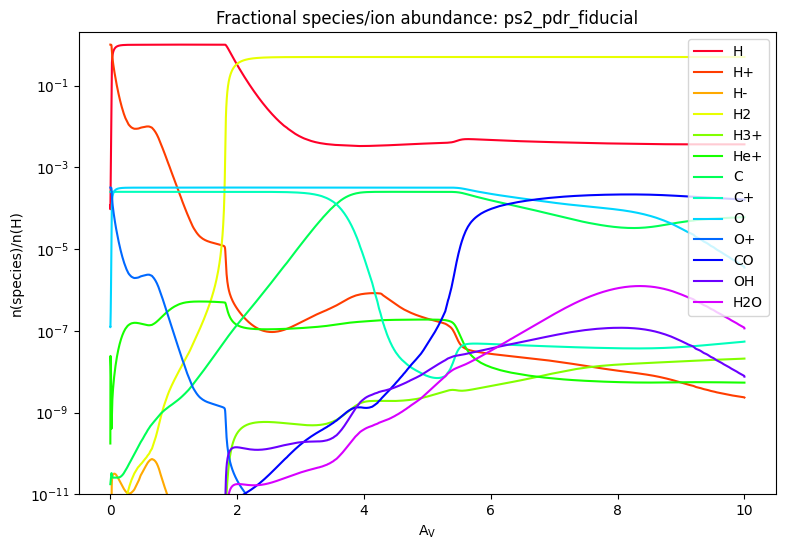

In [8]:
# This is an example of species to plot, you might want to select others from above!
pltspecies=['H','H+','H-','H2','H3+','He+','C','C+','O','O+','CO','OH','H2O']
nspecies=len(pltspecies)

cm = plt.get_cmap('gist_rainbow')
colors=cm(np.arange(nspecies)/nspecies)

plt.figure(figsize=(9,6)) 
for species,color in zip(pltspecies,colors):
    plt.plot(t_mol['AV(point)'],t_mol[species]/t_ovr['hden'],label=species,color=color)
   
plt.legend()
plt.yscale("log")
plt.xlabel("$A_V$")
plt.ylabel("n(species)/n(H)")
plt.title("Fractional species/ion abundance: "+model_name)
#plt.xlim((2,5))
plt.ylim((1e-11,2))
plt.show()

